In [ ]:
# Heatmap of posterior mean probabilities for combined results (original order)
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataloader import load_data


def _sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))


def _dataset_shape() -> tuple:
    A, X_cov, condition_list = load_data()
    A_2d = A[:, :, 0] if A.ndim == 3 else A
    return A_2d.shape  # (I, C_data)


def _reconstruct_logits_from_params(payload: dict) -> np.ndarray | None:
    """
    Attempt to reconstruct logits draws (num_draws, I, C_eff) from combined parameters.
    Uses condition-level effects and optional global patient effect.
    """
    I, C_data = _dataset_shape()

    # Prefer directly provided beta_cond; else reconstruct from tau * lambdas
    if 'beta_cond' in payload:
        beta_cond = np.asarray(payload['beta_cond'])  # (S, C_param)
    elif 'tau' in payload and 'lambdas' in payload:
        tau = np.asarray(payload['tau']).reshape(-1, 1)  # (S,1)
        lambdas = np.asarray(payload['lambdas'])        # (S,C_param)
        if tau.shape[0] != lambdas.shape[0]:
            return None
        beta_cond = tau * lambdas
    else:
        return None

    S = beta_cond.shape[0]
    C_param = beta_cond.shape[1]

    # Optional global patient effect per draw
    beta_pat = payload.get('beta_pat', None)
    if beta_pat is not None:
        beta_pat = np.asarray(beta_pat)
        # Ensure shape (S,) for broadcasting
        if beta_pat.ndim == 0:
            beta_pat = np.full((S,), float(beta_pat))
        elif beta_pat.ndim > 1:
            beta_pat = beta_pat.reshape(S)
    else:
        beta_pat = np.zeros((S,), dtype=float)

    # Align condition dimension to dataset
    C_eff = min(C_param, C_data)
    if C_param != C_data:
        beta_cond = beta_cond[:, :C_eff]

    # Broadcast over patients I
    logits = np.tile(beta_cond[:, None, :], (1, I, 1))  # (S, I, C_eff)
    if beta_pat is not None:
        logits = logits + beta_pat[:, None, None]

    return logits


def load_posterior_mean_probability_matrix(results_dir: str) -> np.ndarray:
    """
    Load posterior samples from a results directory and return the posterior mean
    probability matrix of shape (num_patients, num_conditions).

    Supports:
    - Single-shard outputs: mcmc_samples.npy with key 'Lambda' (logits) or 'f'
    - Combined outputs: combined_post_samples.npy possibly with key 'p' (probabilities)
    - Parameter-only combined outputs: reconstruct logits from parameters
    """
    if not os.path.isdir(results_dir):
        raise FileNotFoundError(f"Results directory not found: {results_dir}")

    combined_path = os.path.join(results_dir, 'combined_post_samples.npy')
    shard_path = os.path.join(results_dir, 'mcmc_samples.npy')

    if os.path.exists(combined_path):
        payload = np.load(combined_path, allow_pickle=True).item()
        if 'p' in payload:
            p = payload['p']
            if p.ndim == 2:
                return np.asarray(p)
            elif p.ndim == 3:
                return np.mean(p, axis=0)
        for logits_key in ('f', 'Lambda'):
            if logits_key in payload:
                logits = np.asarray(payload[logits_key])
                if logits.ndim == 2:
                    return _sigmoid(logits)
                elif logits.ndim == 3:
                    return _sigmoid(logits).mean(axis=0)
        # Try reconstructing from parameters
        logits_draws = _reconstruct_logits_from_params(payload)
        if logits_draws is not None:
            return _sigmoid(logits_draws).mean(axis=0)
        raise KeyError("Neither 'p' nor logits ('f'/'Lambda') found in combined results, and reconstruction failed.")

    if os.path.exists(shard_path):
        samples = np.load(shard_path, allow_pickle=True).item()
        for logits_key in ('Lambda', 'f'):
            if logits_key in samples:
                logits = np.asarray(samples[logits_key])
                if logits.ndim == 2:
                    return _sigmoid(logits)
                elif logits.ndim == 3:
                    return _sigmoid(logits).mean(axis=0)
        raise KeyError("Expected 'Lambda' or 'f' in shard samples to compute probabilities.")

    raise FileNotFoundError(
        f"No results files found in {results_dir}. Expected 'mcmc_samples.npy' or 'combined_post_samples.npy'."
    )


# === Set this to your results directory (combined or single shard) ===
# Example: results_dir = '/Users/bernardo/Documents/Code/PharmacyAlloc/Res/gmrf_20250816_134744'
results_dir = '/Users/bernardo/Documents/Code/PharmacyAlloc/Res/sharded_hierarchical_gp_20250903_144324'

# Load posterior mean probabilities
P_mean = load_posterior_mean_probability_matrix(results_dir)
print(f"Loaded posterior mean probability matrix with shape: {P_mean.shape}")

# Plot heatmap in original order
plt.figure(figsize=(10, 8))
sns.heatmap(P_mean, cmap='viridis', vmin=0.0, vmax=1.0, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title('Posterior Mean Probability (Original Order)')
plt.xlabel('Diseases (original order)')
plt.ylabel('Patients (original order)')
plt.tight_layout()
plt.show()


KeyError: "Neither 'p' nor logits ('f'/'Lambda') found in combined results."

Loaded probability draws: (4000, 499, 43); std matrix shape: (499, 43)


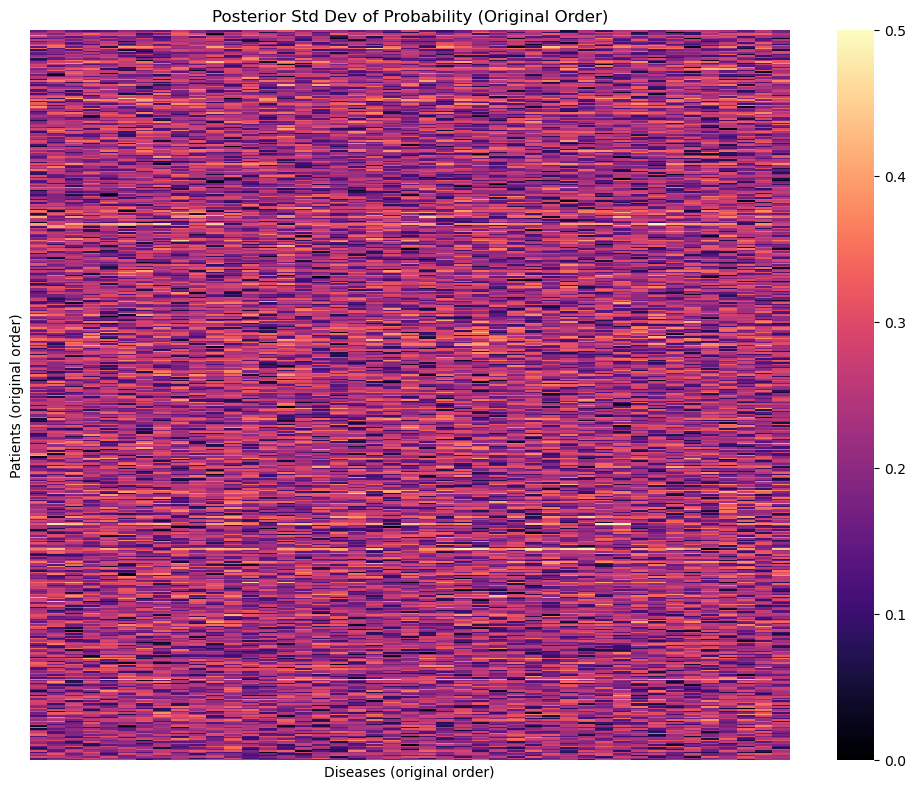

In [ ]:
# Heatmap of posterior standard deviation of probabilities (original order)
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataloader import load_data


def load_probability_draws(results_dir: str) -> np.ndarray:
    """
    Return posterior draws of probabilities with shape (num_draws, I, C).
    Supports both combined and single-shard result folders.
    If neither p nor logits are present in combined results, reconstruct from parameters.
    """
    combined_path = os.path.join(results_dir, 'combined_post_samples.npy')
    shard_path = os.path.join(results_dir, 'mcmc_samples.npy')

    def _sigmoid(x: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-x))

    def _dataset_shape():
        A, X_cov, condition_list = load_data()
        A_2d = A[:, :, 0] if A.ndim == 3 else A
        return A_2d.shape

    def _reconstruct_logits_from_params(payload: dict) -> np.ndarray | None:
        I, C_data = _dataset_shape()
        if 'p' in payload:
            p = np.asarray(payload['p'])
            if p.ndim == 3:
                return p  # already probabilities draws
        if 'beta_cond' in payload:
            beta_cond = np.asarray(payload['beta_cond'])
        elif 'tau' in payload and 'lambdas' in payload:
            tau = np.asarray(payload['tau']).reshape(-1, 1)
            lambdas = np.asarray(payload['lambdas'])
            if tau.shape[0] != lambdas.shape[0]:
                return None
            beta_cond = tau * lambdas
        else:
            return None
        S, C_param = beta_cond.shape
        beta_pat = payload.get('beta_pat', None)
        if beta_pat is not None:
            beta_pat = np.asarray(beta_pat)
            if beta_pat.ndim == 0:
                beta_pat = np.full((S,), float(beta_pat))
            elif beta_pat.ndim > 1:
                beta_pat = beta_pat.reshape(S)
        else:
            beta_pat = np.zeros((S,), dtype=float)
        C_eff = min(C_param, C_data)
        if C_param != C_data:
            beta_cond = beta_cond[:, :C_eff]
        logits = np.tile(beta_cond[:, None, :], (1, I, 1))
        logits = logits + beta_pat[:, None, None]
        return logits

    if os.path.exists(combined_path):
        payload = np.load(combined_path, allow_pickle=True).item()
        if 'p' in payload:
            p = np.asarray(payload['p'])
            if p.ndim == 3:
                return p
            elif p.ndim == 2:
                # cannot compute std across draws from a single matrix
                for logits_key in ('f', 'Lambda'):
                    if logits_key in payload:
                        logits = np.asarray(payload[logits_key])
                        if logits.ndim == 3:
                            return _sigmoid(logits)
                # Try reconstruction from params for draws
                logits_draws = _reconstruct_logits_from_params(payload)
                if logits_draws is not None:
                    return _sigmoid(logits_draws)
                raise ValueError("Combined results provide only a single 2D probability matrix; per-draw std is unavailable.")
        # If 'p' missing, try logits
        for logits_key in ('f', 'Lambda'):
            if logits_key in payload:
                logits = np.asarray(payload[logits_key])
                if logits.ndim == 3:
                    return _sigmoid(logits)
                elif logits.ndim == 2:
                    # Try reconstruction from params for draws
                    logits_draws = _reconstruct_logits_from_params(payload)
                    if logits_draws is not None:
                        return _sigmoid(logits_draws)
                    raise ValueError("Combined results contain only a single 2D latent matrix; per-draw std is unavailable.")
        # Try reconstruction from params if available
        logits_draws = _reconstruct_logits_from_params(payload)
        if logits_draws is not None:
            return _sigmoid(logits_draws)
        raise KeyError("No suitable keys found in combined results to derive probability draws.")

    if os.path.exists(shard_path):
        samples = np.load(shard_path, allow_pickle=True).item()
        for logits_key in ('Lambda', 'f'):
            if logits_key in samples:
                logits = np.asarray(samples[logits_key])
                if logits.ndim == 3:
                    return _sigmoid(logits)
                elif logits.ndim == 2:
                    raise ValueError("Shard results contain only a single 2D latent matrix; per-draw std is unavailable.")
        raise KeyError("Expected 'Lambda' or 'f' in shard samples to derive probability draws.")

    raise FileNotFoundError(
        f"No results files found in {results_dir}. Expected 'mcmc_samples.npy' or 'combined_post_samples.npy'."
    )


# Use the same results_dir defined previously
if not results_dir:
    raise RuntimeError("Please set 'results_dir' in the previous cell before running this one.")

# Load per-draw probabilities and compute std across draws
p_draws = load_probability_draws(results_dir)
P_std = np.std(p_draws, axis=0)
print(f"Loaded probability draws: {p_draws.shape}; std matrix shape: {P_std.shape}")

# Plot heatmap of posterior std; std of Bernoulli probs is in [0, 0.5]
plt.figure(figsize=(10, 8))
sns.heatmap(P_std, cmap='magma', vmin=0.0, vmax=0.5, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title('Posterior Std Dev of Probability (Original Order)')
plt.xlabel('Diseases (original order)')
plt.ylabel('Patients (original order)')
plt.tight_layout()
plt.show()


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from dataloader import load_data

# Load ground truth from dataloader and predicted probabilities from results

def load_ground_truth_from_dataloader() -> np.ndarray:
    """
    Load A from dataloader, convert to 2D patient-by-condition binary matrix in {0,1}.
    If A is 3D (patients x conditions x visits), use the first visit.
    If A is in {-1, 1}, convert to {0, 1}.
    """
    A, X_cov, condition_list = load_data()
    A_2d = A[:, :, 0] if A.ndim == 3 else A
    if np.min(A_2d) < 0:
        A_2d = (A_2d + 1) / 2
    return A_2d.astype(int)


def load_predicted_probs(results_dir):
    """
    Loads the mean predicted probabilities from the posterior draws.
    """
    p_draws = load_probability_draws(results_dir)
    return np.mean(p_draws, axis=0)

# Get predictions then align ground truth to predicted shape
P_pred = load_predicted_probs(results_dir)
A_true_full = load_ground_truth_from_dataloader()
A_true = A_true_full[: P_pred.shape[0], : P_pred.shape[1]]

# Binarize predictions at 0.5 threshold
A_pred = (P_pred >= 0.5).astype(int)

# Flatten for confusion matrix computation
y_true = A_true.flatten()
y_pred = A_pred.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Optionally, print classification report for more detail
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))


Confusion Matrix:
[[10012  9954]
 [  764   727]]

Classification Report:
              precision    recall  f1-score   support

           0      0.929     0.501     0.651     19966
           1      0.068     0.488     0.119      1491

    accuracy                          0.500     21457
   macro avg      0.499     0.495     0.385     21457
weighted avg      0.869     0.500     0.614     21457



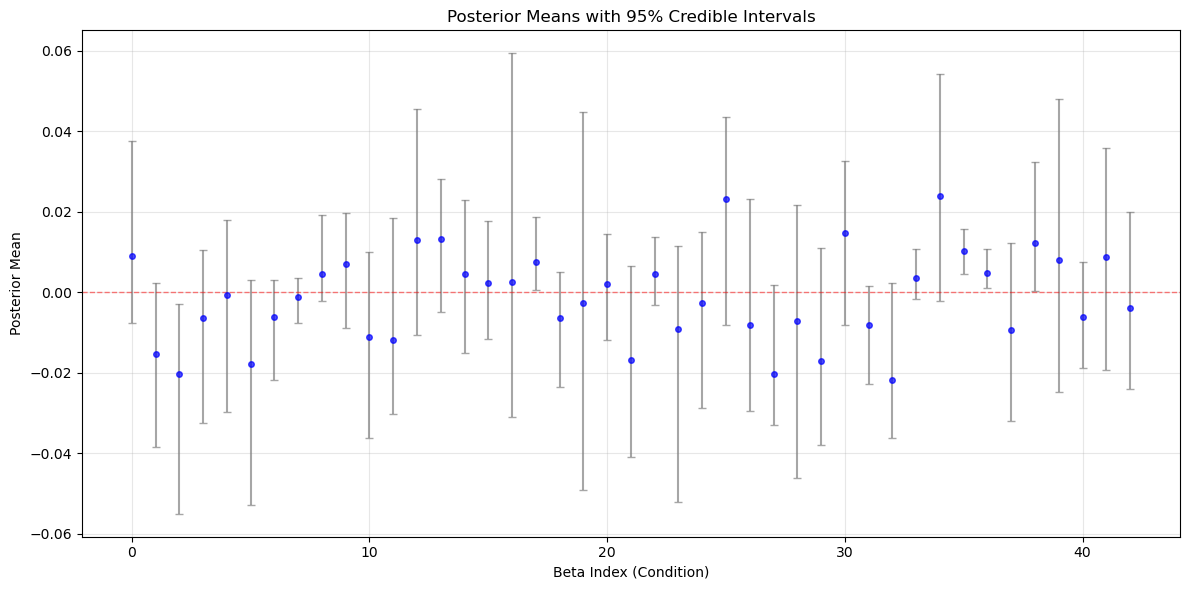


Summary of Beta Parameters:
Number of conditions: 43
Mean of all beta means: -0.0012
Standard deviation of beta means: 0.0114
Range: [-0.0218, 0.0239]
Number of betas with 95% CI excluding zero: 5


In [20]:
num_betas = beta_samples.shape[1]

# Compute posterior mean and 95% credible interval for each beta
beta_means = np.mean(beta_samples, axis=0)
beta_lower = np.percentile(beta_samples, 2.5, axis=0)
beta_upper = np.percentile(beta_samples, 97.5, axis=0)

# Compute error bars (always positive)
yerr_lower = np.abs(beta_means - beta_lower)
yerr_upper = np.abs(beta_upper - beta_means)
yerr = np.vstack([yerr_lower, yerr_upper])

# Plot posterior means with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(range(num_betas), beta_means, yerr=yerr, 
             capsize=3, capthick=1, fmt='o', markersize=4, 
             color='blue', ecolor='gray', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
plt.xlabel('Beta Index (Condition)')
plt.ylabel('Posterior Mean')
plt.title('Posterior Means with 95% Credible Intervals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary of Beta Parameters:")
print(f"Number of conditions: {num_betas}")
print(f"Mean of all beta means: {np.mean(beta_means):.4f}")
print(f"Standard deviation of beta means: {np.std(beta_means):.4f}")
print(f"Range: [{np.min(beta_means):.4f}, {np.max(beta_means):.4f}]")

# Count how many betas have credible intervals that exclude zero
excludes_zero = (beta_lower > 0) | (beta_upper < 0)
print(f"Number of betas with 95% CI excluding zero: {np.sum(excludes_zero)}")
